In [ ]:
!pip install torch torchvision opencv-python matplotlib timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:00


In [ ]:

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# 1. Load MiDaS model from PyTorch Hub
model_type = "DPT_Large"  # Use "DPT_Large" for high accuracy, "MiDaS_small" for faster inference
midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
midas.eval()

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:07<00:00, 192MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
# 2. Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
# 3. Load the transforms for preprocessing the image
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:

# 4. Function to load and preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = midas_transforms(img).to(device)
    return input_batch, img

In [ ]:
# 5. Function to perform depth estimation
def estimate_depth(input_batch):
    with torch.no_grad():
        prediction = midas(input_batch)

    # Ensure correct dimensions (add channel if necessary)
    if prediction.dim() == 3:
        prediction = prediction.unsqueeze(1)

    return prediction

In [ ]:
# 6. Function to visualize the depth map
def show_depth_map(prediction, img):
    # Resize prediction to original image size
    prediction = torch.nn.functional.interpolate(
        prediction,
        size=img.shape[:2],  # (height, width)
        mode="bicubic",
        align_corners=False,
    )

    # Convert to numpy array and normalize
    prediction = prediction.squeeze().cpu().numpy()
    depth_map = (prediction - prediction.min()) / (prediction.max() - prediction.min())

    # Display the depth map
    plt.imshow(depth_map, cmap="inferno")
    plt.axis("off")
    plt.show()

In [ ]:
import cv2

# 7. Function to generate a 3D point cloud from the depth map
def generate_point_cloud(depth_map, img):
    h, w = depth_map.shape

    # Resize the image to match the depth map's dimensions
    img_resized = cv2.resize(img, (w, h))  # Resize to (width, height)

    f = 500  # Focal length, you can adjust this for different effects

    # Generate pixel coordinates in 3D space
    i, j = np.indices((h, w))
    z = depth_map

    # Normalize the image's pixel values
    x = (i - w / 2) * z / f
    y = (j - h / 2) * z / f

    # Flatten and stack into point cloud format
    points_3d = np.vstack((x.flatten(), y.flatten(), z.flatten())).T

    # Reshape the resized image colors to match the number of points
    colors = img_resized.reshape(h * w, 3) / 255.0  # Normalize colors to [0, 1]

    return points_3d, colors


In [ ]:
def plot_point_cloud(points_3d, colors):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Ensure the number of points matches the colors array
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=colors, s=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [ ]:
def main(image_path):
    # Step 1: Preprocess the image
    input_batch, img = preprocess_image(image_path)

    # Step 2: Estimate depth
    prediction = estimate_depth(input_batch)

    # Step 3: Visualize the depth map
    show_depth_map(prediction, img)

    # Step 4: Generate a 3D point cloud
    depth_map = prediction.squeeze().cpu().numpy()
    points_3d, colors = generate_point_cloud(depth_map, img)

    # Step 5: Visualize the 3D point cloud
    plot_point_cloud(points_3d, colors)


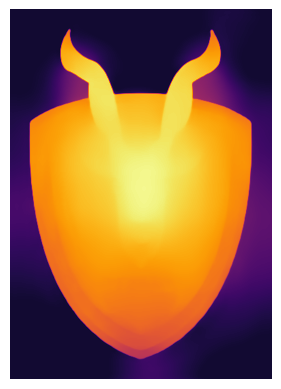

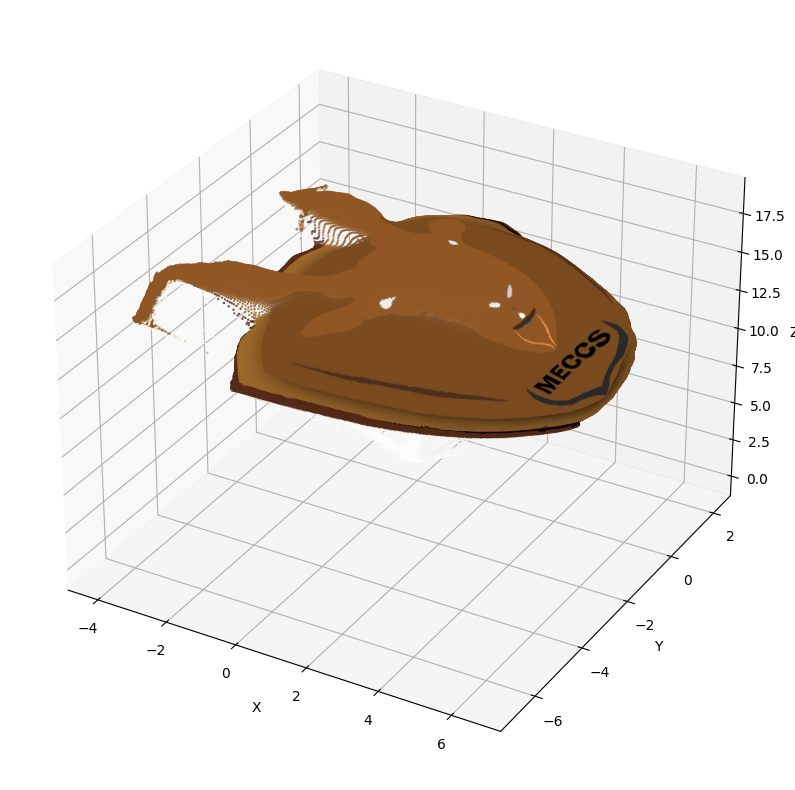

In [ ]:
# Run the entire pipeline on a sample image
image_path = "/content/WhatsApp Image 2024-10-13 at 6.20.13 PM.jpeg"  # Replace with your image path
main(image_path)